In [213]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Load Data 

In [214]:
def read_data() -> pd.DataFrame: 
  dataset = pd.read_csv("Student_Performance.csv")
  return dataset

df = read_data()
df.head()

,student_id,age,gender,school_type,parent_education,study_hours,attendance_percentage,internet_access,travel_time,extra_activities,study_method,math_score,science_score,english_score,overall_score,final_grade
0,1,14,male,public,post graduate,3.1,84.3,yes,<15 min,yes,notes,42.7,55.4,57.0,53.1,e
1,2,18,female,public,graduate,3.7,87.8,yes,>60 min,no,textbook,57.6,68.8,64.8,61.3,d
2,3,17,female,private,post graduate,7.9,65.5,no,<15 min,no,notes,84.8,95.0,79.2,89.6,b
3,4,16,other,public,high school,1.1,58.1,no,15-30 min,no,notes,44.4,27.5,54.7,41.6,e
4,5,16,female,public,high school,1.3,61.0,yes,30-60 min,yes,group study,8.9,32.7,30.0,25.4,f


### Histogramm settings

In [215]:
config = SimpleNamespace(
  data= df, 
  shrink = 0.3, 
  discrete = True, 
  color = "darkblue"
)

### Visualize Dataset for Powerpoint slides

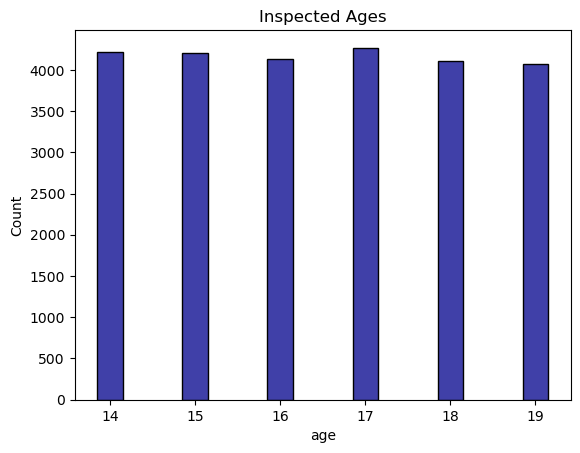

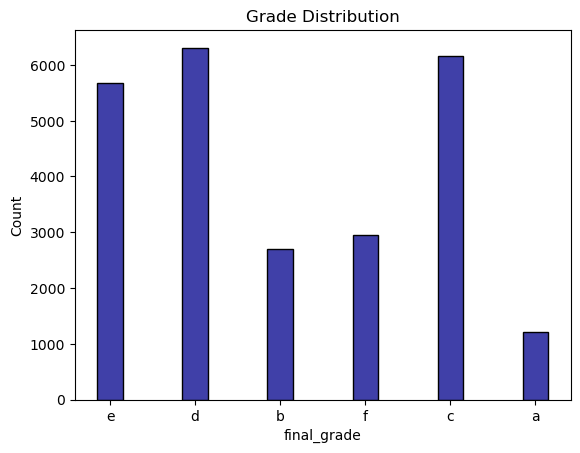

In [216]:
def simple_plot(x_axis, title="") ->None: 
  sns.histplot(data=config.data, x=x_axis, discrete=config.discrete, 
               shrink=config.shrink, color=config.color)
  plt.title(title)
  plt.show()

##just call the function with which attribute you want to be displayed oin the x axis and the title of the histogramm
simple_plot(x_axis="age", title="Inspected Ages")
simple_plot(x_axis="final_grade", title="Grade Distribution")

### Check how the parents' education distributes to check whether a comparison based on grouping data is needed

In [217]:
print(df["parent_education"].value_counts())

parent_education
diploma          4314
high school      4205
post graduate    4196
graduate         4127
no formal        4079
phd              4079
Name: count, dtype: int64


### Split data into each parent eduaction category and create a map

In [218]:
df_parent_education = df["parent_education"]

df_diploma = df[df_parent_education == "diploma"]
df_high_school = df[df_parent_education == "high school"]
df_post_graduate = df[df_parent_education == "post graduate"]
df_graduate = df[df_parent_education == "graduate"]
df_no_formal = df[df_parent_education == "no formal"]
df_phd = df[df_parent_education == "phd"]

parent_edu_df_map = {
  "diploma": df_diploma, 
  "high school": df_high_school, 
  "post graduate": df_post_graduate, 
  "graduate": df_graduate, 
  "no formal": df_no_formal, 
  "phd": df_phd
}

### Check whether the subgroups are normally distributed

Skew:     -0.12352804355372209
Kurtosis: -0.8279935497576449


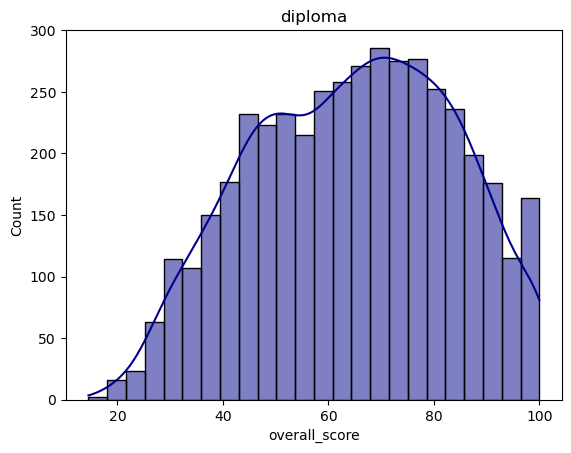

Skew:     0.01961055427036506
Kurtosis: -0.8796724193287817


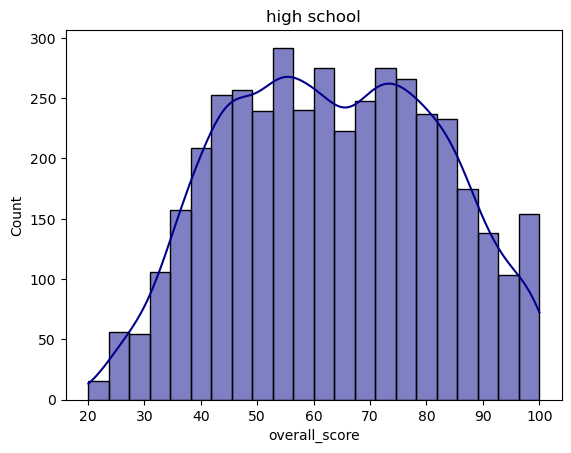

Skew:     -0.06058618046914047
Kurtosis: -0.8669533181044589


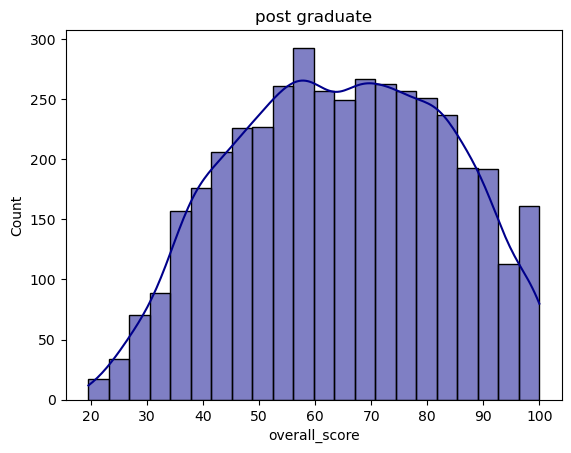

Skew:     -0.06664324906306196
Kurtosis: -0.9147121388403585


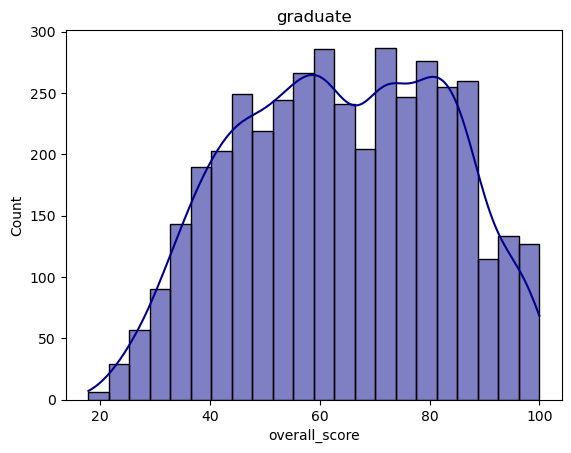

Skew:     -0.032354063238267346
Kurtosis: -0.8824396668588386


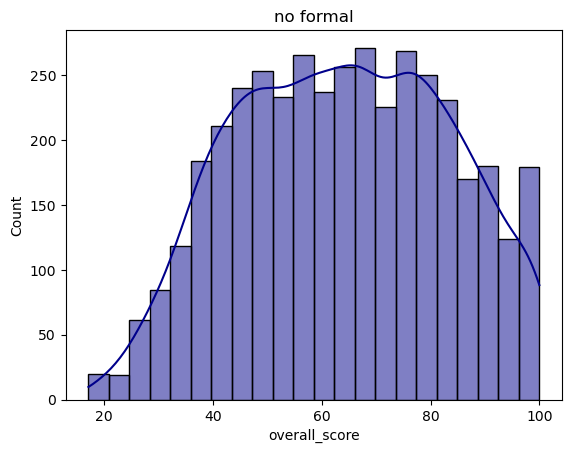

Skew:     -0.0002327806619147788
Kurtosis: -0.8361392799431835


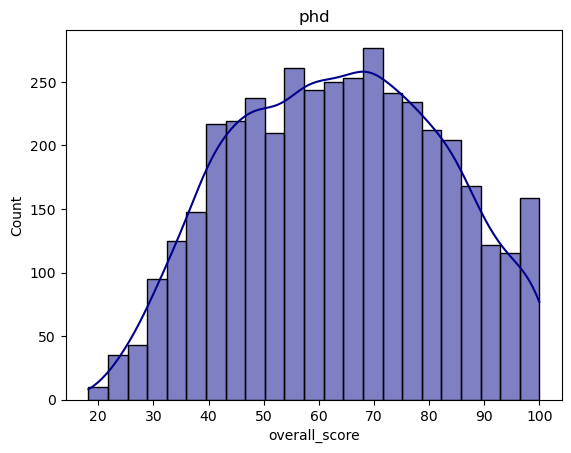

In [219]:
## One of the following functions can be used to plot a Q-Q plot, a normal histopgramm or both next to each other
########################################################################################################################
def plot_normal_distribution(dataset, title) -> None: 
  sns.histplot(data=dataset["overall_score"], kde=True, color=config.color)
  plt.title(title)
  plt.show()

########################################################################################################################
def plot_q_q(dataset, title) ->None: 
  stats.probplot(dataset["overall_score"], dist="norm", plot=plt)
  plt.title(title)
  plt.show()

########################################################################################################################
def plot_q_and_normal(dataset, title) ->None: 
  fig, axes = plt.subplots(1, 2, figsize=(10,4))

  sns.histplot(dataset["overall_score"], kde=True, ax=axes[0], color=config.color)
  axes[0].set_title(f"{title} – Histogram")

  stats.probplot(dataset["overall_score"], dist="norm", plot=axes[1])
  axes[1].set_title("Q–Q Plot")

  plt.show()


for title, group in parent_edu_df_map.items(): 
  ##TODO: double check this, maybe just use the pvalue comparison ??
  skew = stats.skew(group["overall_score"])
  kurtosis = stats.kurtosis(group["overall_score"])
  print(f"Skew:     {skew}")
  print(f"Kurtosis: {kurtosis}")
  if (abs(skew) >= 1 or abs(kurtosis) >= 2): 
    print("Data is not stable enough!")
  plot_normal_distribution(group, title)

### Check for equal variances 

In [220]:
levene_test = stats.levene(
  *[group["overall_score"] for group in parent_edu_df_map.values()], 
  center="median"
)
alpha = 0.05
print(f"Levene Statistic: {levene_test.statistic}")
print(f"Levene pvalue:    {levene_test.pvalue}")
if (levene_test.pvalue >= alpha): 
  print("We cannot reject equal variances and therefore can reason for using the ANOVA Test for comparing Datasets")
else: 
  print("Recject equal variances, we need to use Welch ANOVA")

Levene Statistic: 1.3725055475427732
Levene pvalue:    0.23110771120969073
We cannot reject equal variances and therefore can reason for using the ANOVA Test for comparing Datasets


### Use ANOVA test to compare datsets and test if differences exist

In [221]:
f_statistic, p_value = stats.f_oneway(*[group["overall_score"] for group in parent_edu_df_map.values()])
print(f"F-statistic:  {f_statistic}")
print(f"P-value:      {p_value}")
if (p_value < alpha): 
  print("Reject the Null-Hypothesis: Parental education has a significant impact on student performance.")
else:
  print("We cannot reject the Null-hypthesis: There is no statistically significant evidence that parental education affects student performance.")

F-statistic:  3.1560074727938328
P-value:      0.00751355710251115
Reject the Null-Hypothesis: Parental education has a significant impact on student performance.


### Find out which groups differ and find the pattern

Education Level: diploma              Mean:  64.651       Std:  19.037
Education Level: high school          Mean:  63.386       Std:  18.656
Education Level: post graduate        Mean:  64.563       Std:  18.830
Education Level: graduate             Mean:  63.957       Std:  18.837
Education Level: no formal            Mean:  63.907       Std:  19.328
Education Level: phd                  Mean:  63.539       Std:  18.880


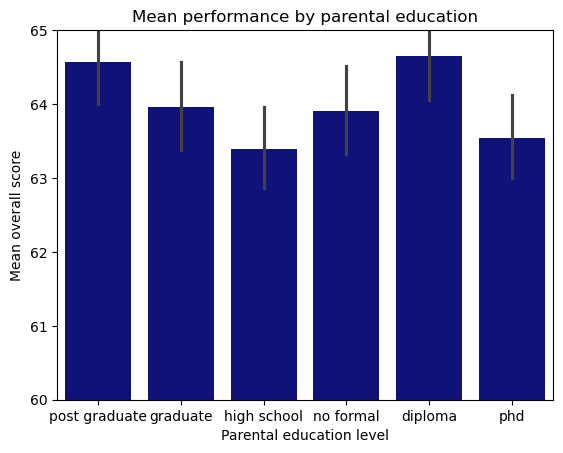

In [222]:
for title, group in parent_edu_df_map.items(): 
  print(
    f"Education Level: {title:<20} "
    f"Mean: {group['overall_score'].mean():>7.3f}       "
    f"Std: {group['overall_score'].std():>7.3f}"
  )

##TODO: replace with a nicer visual representation

sns.barplot(
    data=df,
    x="parent_education",
    y="overall_score", 
    color=config.color
)

plt.ylim(60, 65)
plt.xlabel("Parental education level")
plt.ylabel("Mean overall score")
plt.title("Mean performance by parental education")
plt.show()



### Use Two-Way-ANOVA to check how parental education in different age groups affects student performance

In [223]:
model = ols('overall_score ~ C(parent_education) + C(age) + C(parent_education):C(age)', data=df).fit()
two_way_anova = sm.stats.anova_lm(model, type=2)
p_parent_education = two_way_anova.loc["C(parent_education)", "PR(>F)"]
p_age = two_way_anova.loc["C(age)", "PR(>F)"]
p_interaction = two_way_anova.loc["C(parent_education):C(age)", "PR(>F)"]

# parent education
print(f"p-value parent education: {p_parent_education:.8f}")
if (p_parent_education < alpha): 
  print("Reject the Null-Hypothesis: Parental education has a significant impact on student performance.\n")
else:
  print("We cannot reject the Null-Hypthesis: There is no statistically significant evidence that parental education affects student performance.\n")

# age
print(f"p-value age:              {p_age:.8f}")
if (p_age < alpha):
  print("Reject the Null-Hypothesis: Age has a significant impact on student performance.\n")
else:
  print("We cannot reject the Null-Hypthesis: There is no statistically significant evidence that age affects student performance.\n")

# interaction parent education/age
print(f"p-value interaction:      {p_interaction:.8f}")
if (p_interaction < alpha):
  print("Reject the Null-Hypothesis: The effect of parental education on performance differs between age groups.\n")
else:
  print("We cannot reject the Null-Hypthesis: There is no statistically significant evidence that the effect of parental education depends on age.\n")

p-value parent education: 0.00746337
Reject the Null-Hypothesis: Parental education has a significant impact on student performance.

p-value age:              0.19046230
We cannot reject the Null-Hypthesis: There is no statistically significant evidence that age affects student performance.

p-value interaction:      0.00365483
Reject the Null-Hypothesis: The effect of parental education on performance differs between age groups.



### Graphically display the results of Two-Way-ANOVA

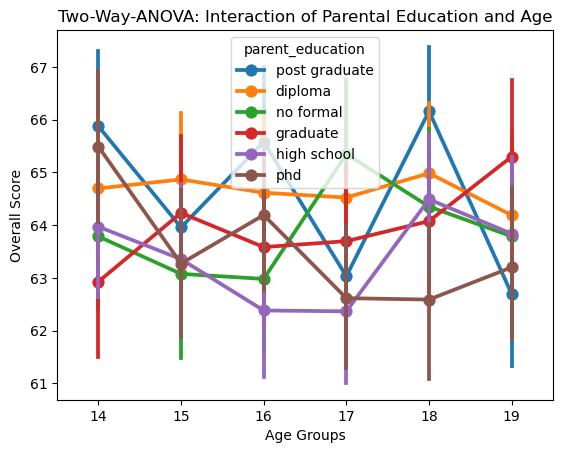

In [224]:
sns.pointplot(data=df, x="age", y="overall_score", hue="parent_education")
plt.title("Two-Way-ANOVA: Interaction of Parental Education and Age")
plt.ylabel("Overall Score")
plt.xlabel("Age Groups")
plt.show()

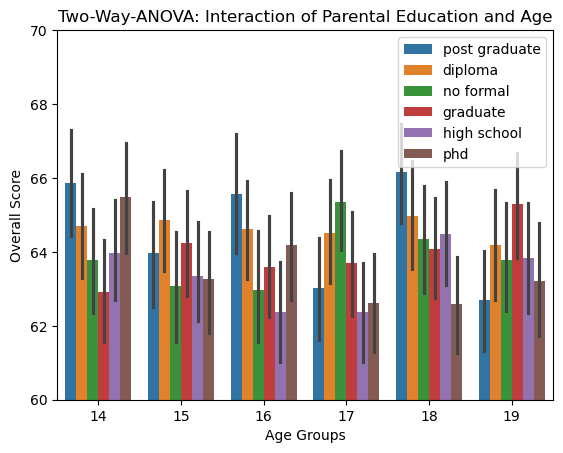

In [225]:
sns.barplot(data=df, x="age", y="overall_score", hue="parent_education")
plt.title("Two-Way-ANOVA: Interaction of Parental Education and Age")
plt.ylim(60, 70)
plt.ylabel("Overall Score")
plt.xlabel("Age Groups")
plt.legend(loc="upper right")
plt.show()